In [7]:
!pip -q install xgboost lightgbm catboost shap scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.7 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
import joblib

from scipy.stats import randint, uniform, loguniform

In [9]:
from google.colab import files
uploaded = files.upload()

Saving ml learnning prject data base.csv to ml learnning prject data base.csv


In [10]:
DATA_PATH = "ml learnning prject data base.csv"  # change if your filename differs
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

display(df.head())
display(df.describe(include=[np.number]).T)

Shape: (10000, 10)
Columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']

Missing values:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Duplicates: 0


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Target,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64
Failure Type
No Failure                  96.52
Heat Dissipation Failure     1.12
Power Failure                0.95
Overstrain Failure           0.78
Tool Wear Failure            0.45
Random Failures              0.18
Name: proportion, dtype: float64


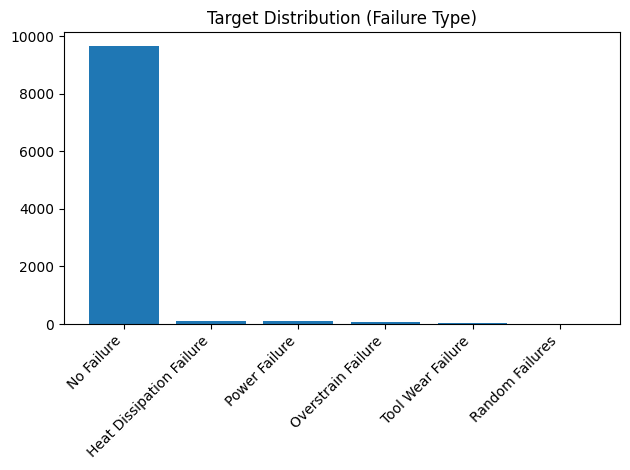

In [11]:
TARGET_COL = "Failure Type"
print(df[TARGET_COL].value_counts())
print((df[TARGET_COL].value_counts(normalize=True)*100).round(2))

counts = df[TARGET_COL].value_counts()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Target Distribution (Failure Type)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [12]:
IRRELEVANT_COLS = ["UDI", "Product ID", "Target"]  # IDs + leakage
df = df.drop_duplicates().reset_index(drop=True)

df_clean = df.drop(columns=[c for c in IRRELEVANT_COLS if c in df.columns], errors="ignore").copy()
print("Removed:", [c for c in IRRELEVANT_COLS if c in df.columns])
print("Remaining columns:", df_clean.columns.tolist())

y_raw = df_clean[TARGET_COL].astype(str)
X = df_clean.drop(columns=[TARGET_COL]).copy()

print("X shape:", X.shape, "y shape:", y_raw.shape)
print("X columns:", X.columns.tolist())

Removed: ['UDI', 'Product ID', 'Target']
Remaining columns: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Failure Type']
X shape: (10000, 6) y shape: (10000,)
X columns: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [13]:
REMOVE_OUTLIERS = True  # set False if your doctor doesn't want outlier removal

numeric_cols_tmp = X.select_dtypes(include=[np.number]).columns.tolist()

if REMOVE_OUTLIERS and len(numeric_cols_tmp) > 0:
    Q1 = X[numeric_cols_tmp].quantile(0.25)
    Q3 = X[numeric_cols_tmp].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ((X[numeric_cols_tmp] < (Q1 - 1.5*IQR)) | (X[numeric_cols_tmp] > (Q3 + 1.5*IQR))).any(axis=1)
    print("Outlier rows:", int(outlier_mask.sum()))

    X = X.loc[~outlier_mask].reset_index(drop=True)
    y_raw = y_raw.loc[~outlier_mask].reset_index(drop=True)

print("After outliers -> X:", X.shape, "y:", y_raw.shape)

Outlier rows: 459
After outliers -> X: (9541, 6) y: (9541,)


In [14]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols)
    ],
    remainder="drop"
)

Categorical: ['Type']
Numeric: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [15]:
le = LabelEncoder()
y = le.fit_transform(y_raw)
n_classes = len(le.classes_)
print("Classes:", list(le.classes_))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Classes: ['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure', 'Random Failures', 'Tool Wear Failure']
Train: (7632, 6) Test: (1909, 6)


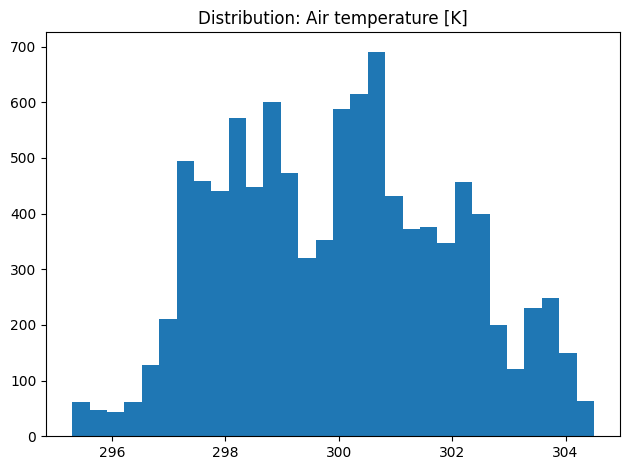

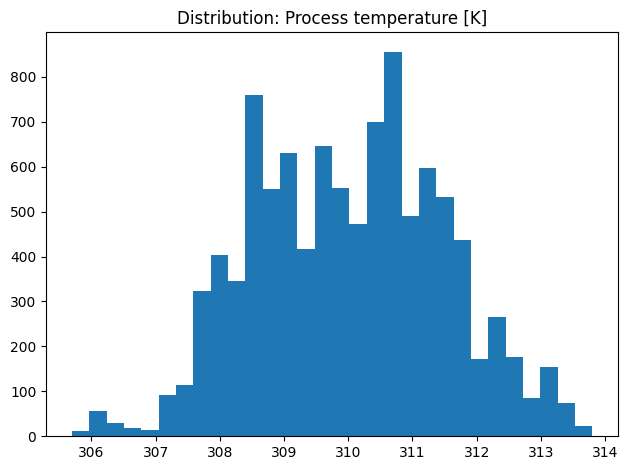

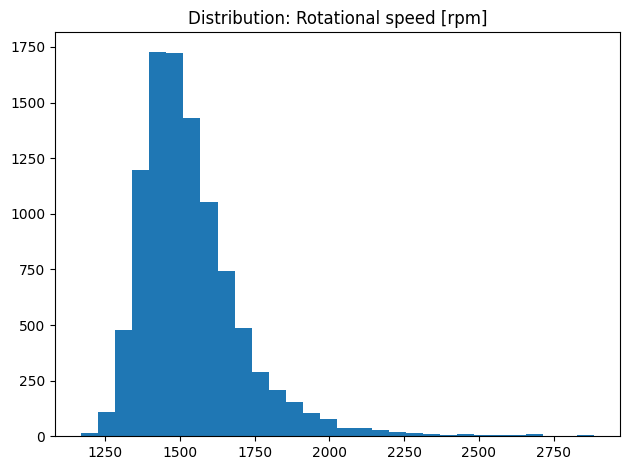

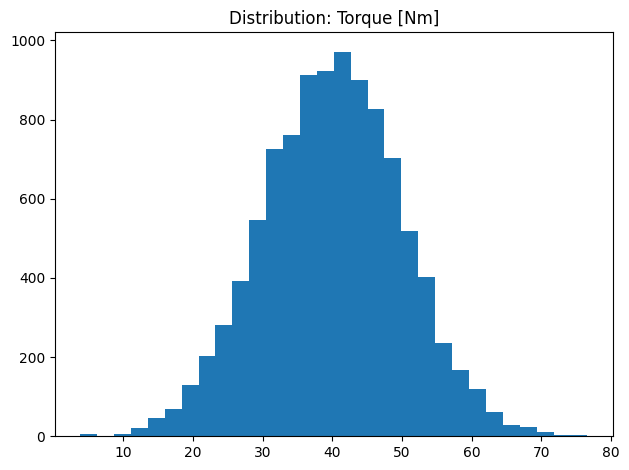

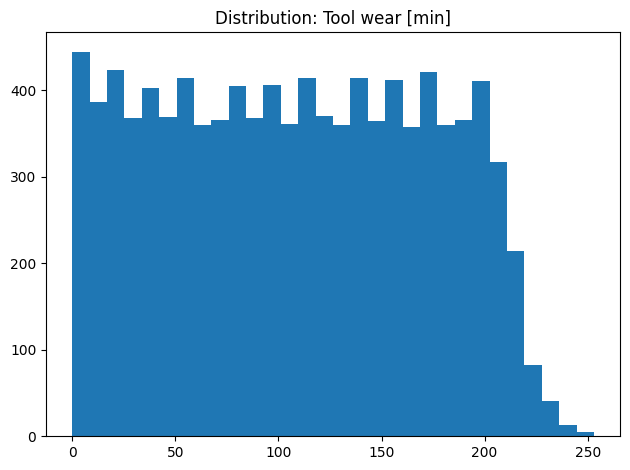

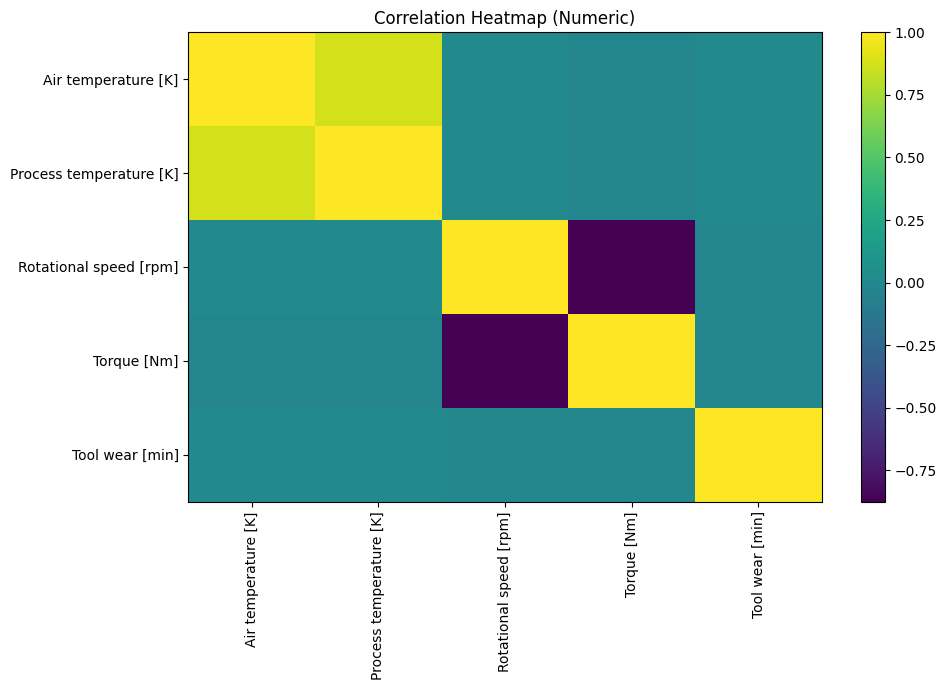

In [16]:
# numeric distributions (limit to first 6)
for c in numeric_cols[:6]:
    plt.figure()
    plt.hist(df_clean[c].dropna(), bins=30)
    plt.title(f"Distribution: {c}")
    plt.tight_layout()
    plt.show()

# correlation heatmap
if len(numeric_cols) >= 2:
    corr = df_clean[numeric_cols].corr(numeric_only=True)
    plt.figure(figsize=(10, 7))
    plt.imshow(corr.values, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation Heatmap (Numeric)")
    plt.tight_layout()
    plt.show()

,feature,mutual_info
3,num__Torque [Nm],0.043242
2,num__Rotational speed [rpm],0.032913
4,num__Tool wear [min],0.026328
0,num__Air temperature [K],0.021700
1,num__Process temperature [K],0.008925
6,cat__Type_L,0.003605
7,cat__Type_M,0.003335
5,cat__Type_H,0.000661


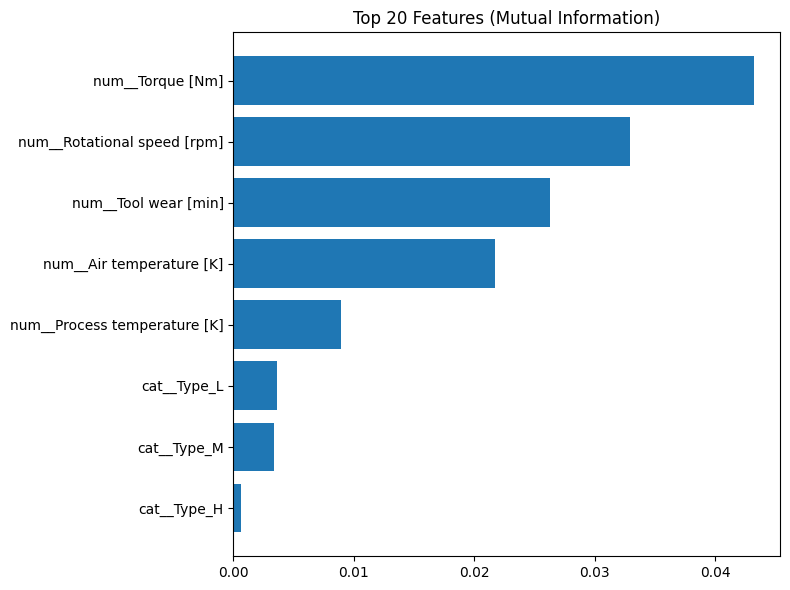

In [17]:
prep_fit = preprocess.fit(X_train, y_train)
Xt = prep_fit.transform(X_train)
if hasattr(Xt, "toarray"):
    Xt = Xt.toarray()

try:
    feat_names = prep_fit.get_feature_names_out()
except Exception:
    feat_names = np.array([f"f{i}" for i in range(Xt.shape[1])])

mi = mutual_info_classif(Xt, y_train, random_state=42)
mi_df = pd.DataFrame({"feature": feat_names, "mutual_info": mi}).sort_values("mutual_info", ascending=False)

display(mi_df.head(20))

top = mi_df.head(20).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(top["feature"], top["mutual_info"])
plt.title("Top 20 Features (Mutual Information)")
plt.tight_layout()
plt.show()

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_scores(pipe):
    scoring = {
        "acc": "accuracy",
        "prec_w": "precision_weighted",
        "rec_w": "recall_weighted",
        "f1_w": "f1_weighted",
        "f1_m": "f1_macro"
    }
    out = cross_validate(pipe, X_train, y_train, cv=skf, scoring=scoring, n_jobs=-1)
    return {k: float(np.mean(v)) for k, v in out.items() if k.startswith("test_")}

def test_scores(pipe):
    y_pred = pipe.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision(weighted)": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall(weighted)": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1(weighted)": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1(macro)": f1_score(y_test, y_pred, average="macro", zero_division=0),
    }

def plot_confusion(pipe, title="Confusion Matrix"):
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    return cm

rows_baseline = []
rows_tuned = []
best_pipes_baseline = {}
best_pipes_tuned = {}

In [19]:
lr = LogisticRegression(max_iter=5000, class_weight="balanced")
lr_pipe = Pipeline([("prep", preprocess), ("model", lr)])

cv = cv_scores(lr_pipe)
lr_pipe.fit(X_train, y_train)
ts = test_scores(lr_pipe)

row = {"Model": "LogisticRegression", "Group": "Non-Ensemble", "Version": "Baseline"}
row.update({f"CV_{k.replace('test_','')}": v for k, v in cv.items()})
row.update({f"Test_{k}": v for k, v in ts.items()})
rows_baseline.append(row)
best_pipes_baseline["LogisticRegression"] = lr_pipe

pd.DataFrame([row])

,Model,Group,Version,CV_acc,CV_prec_w,CV_rec_w,CV_f1_w,CV_f1_m,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,LogisticRegression,Non-Ensemble,Baseline,0.647004,0.976581,0.647004,0.76722,0.36894,0.63803,0.974818,0.63803,0.762452,0.365807


In [20]:
svm = SVC(kernel="rbf", class_weight="balanced")
svm_pipe = Pipeline([("prep", preprocess), ("model", svm)])

cv = cv_scores(svm_pipe)
svm_pipe.fit(X_train, y_train)
ts = test_scores(svm_pipe)

row = {"Model": "SVM_RBF", "Group": "Non-Ensemble", "Version": "Baseline"}
row.update({f"CV_{k.replace('test_','')}": v for k, v in cv.items()})
row.update({f"Test_{k}": v for k, v in ts.items()})
rows_baseline.append(row)
best_pipes_baseline["SVM_RBF"] = svm_pipe

pd.DataFrame([row])

,Model,Group,Version,CV_acc,CV_prec_w,CV_rec_w,CV_f1_w,CV_f1_m,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,SVM_RBF,Non-Ensemble,Baseline,0.850099,0.975393,0.850099,0.902615,0.413742,0.827135,0.97549,0.827135,0.889265,0.431384


In [21]:
knn = KNeighborsClassifier()
knn_pipe = Pipeline([("prep", preprocess), ("model", knn)])

cv = cv_scores(knn_pipe)
knn_pipe.fit(X_train, y_train)
ts = test_scores(knn_pipe)

row = {"Model": "KNN", "Group": "Non-Ensemble", "Version": "Baseline"}
row.update({f"CV_{k.replace('test_','')}": v for k, v in cv.items()})
row.update({f"Test_{k}": v for k, v in ts.items()})
rows_baseline.append(row)
best_pipes_baseline["KNN"] = knn_pipe

pd.DataFrame([row])

,Model,Group,Version,CV_acc,CV_prec_w,CV_rec_w,CV_f1_w,CV_f1_m,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,KNN,Non-Ensemble,Baseline,0.976808,0.966457,0.976808,0.968734,0.323905,0.974856,0.962108,0.974856,0.965631,0.297867


In [22]:
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=n_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)
xgb_pipe = Pipeline([("prep", preprocess), ("model", xgb)])

cv = cv_scores(xgb_pipe)
xgb_pipe.fit(X_train, y_train)
ts = test_scores(xgb_pipe)

row = {"Model": "XGBoost", "Group": "Ensemble", "Version": "Baseline"}
row.update({f"CV_{k.replace('test_','')}": v for k, v in cv.items()})
row.update({f"Test_{k}": v for k, v in ts.items()})
rows_baseline.append(row)
best_pipes_baseline["XGBoost"] = xgb_pipe

pd.DataFrame([row])

,Model,Group,Version,CV_acc,CV_prec_w,CV_rec_w,CV_f1_w,CV_f1_m,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,XGBoost,Ensemble,Baseline,0.985981,0.980732,0.985981,0.982696,0.527624,0.985856,0.983106,0.985856,0.98434,0.604586


In [23]:
lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=n_classes,
    random_state=42,
    n_jobs=-1,
    force_col_wise=True,
    verbosity=-1
)
lgbm_pipe = Pipeline([("prep", preprocess), ("model", lgbm)])

cv = cv_scores(lgbm_pipe)
lgbm_pipe.fit(X_train, y_train)
ts = test_scores(lgbm_pipe)

row = {"Model": "LightGBM", "Group": "Ensemble", "Version": "Baseline"}
row.update({f"CV_{k.replace('test_','')}": v for k, v in cv.items()})
row.update({f"Test_{k}": v for k, v in ts.items()})
rows_baseline.append(row)
best_pipes_baseline["LightGBM"] = lgbm_pipe

pd.DataFrame([row])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Group,Version,CV_acc,CV_prec_w,CV_rec_w,CV_f1_w,CV_f1_m,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,LightGBM,Ensemble,Baseline,0.987684,0.982276,0.987684,0.98449,0.561752,0.989523,0.983837,0.989523,0.986376,0.580147


In [24]:
cat = CatBoostClassifier(loss_function="MultiClass", random_state=42, verbose=0)
cat_pipe = Pipeline([("prep", preprocess), ("model", cat)])

cv = cv_scores(cat_pipe)
cat_pipe.fit(X_train, y_train)
ts = test_scores(cat_pipe)

row = {"Model": "CatBoost", "Group": "Ensemble", "Version": "Baseline"}
row.update({f"CV_{k.replace('test_','')}": v for k, v in cv.items()})
row.update({f"Test_{k}": v for k, v in ts.items()})
rows_baseline.append(row)
best_pipes_baseline["CatBoost"] = cat_pipe

pd.DataFrame([row])

,Model,Group,Version,CV_acc,CV_prec_w,CV_rec_w,CV_f1_w,CV_f1_m,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,CatBoost,Ensemble,Baseline,0.985063,0.977887,0.985063,0.980984,0.485286,0.987428,0.981543,0.987428,0.984244,0.596763


In [25]:
baseline_table = pd.DataFrame(rows_baseline).sort_values(by="Test_F1(weighted)", ascending=False)
baseline_table

,Model,Group,Version,CV_acc,CV_prec_w,CV_rec_w,CV_f1_w,CV_f1_m,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
4,LightGBM,Ensemble,Baseline,0.987684,0.982276,0.987684,0.984490,0.561752,0.989523,0.983837,0.989523,0.986376,0.580147
3,XGBoost,Ensemble,Baseline,0.985981,0.980732,0.985981,0.982696,0.527624,0.985856,0.983106,0.985856,0.984340,0.604586
5,CatBoost,Ensemble,Baseline,0.985063,0.977887,0.985063,0.980984,0.485286,0.987428,0.981543,0.987428,0.984244,0.596763
2,KNN,Non-Ensemble,Baseline,0.976808,0.966457,0.976808,0.968734,0.323905,0.974856,0.962108,0.974856,0.965631,0.297867
1,SVM_RBF,Non-Ensemble,Baseline,0.850099,0.975393,0.850099,0.902615,0.413742,0.827135,0.975490,0.827135,0.889265,0.431384
0,LogisticRegression,Non-Ensemble,Baseline,0.647004,0.976581,0.647004,0.767220,0.368940,0.638030,0.974818,0.638030,0.762452,0.365807


In [26]:
TUNE_CV = 3          # 3 = faster. set 5 if you insist.
NITER_SMALL = 25     # LR/SVM
NITER_MED = 30       # KNN
NITER_ENSEMBLE = 20  # XGB/LGBM

In [27]:
lr = LogisticRegression(max_iter=5000, class_weight="balanced")
lr_dist = {"model__C": loguniform(1e-3, 1e2)}

lr_rand = RandomizedSearchCV(
    Pipeline([("prep", preprocess), ("model", lr)]),
    lr_dist, n_iter=NITER_SMALL, scoring="f1_weighted",
    cv=TUNE_CV, n_jobs=-1, verbose=1, random_state=42
)
lr_rand.fit(X_train, y_train)
lr_best = lr_rand.best_estimator_

row = {
    "Model":"LogisticRegression","Group":"Non-Ensemble","Version":"Tuned(Random)",
    "BestCV_F1_weighted": lr_rand.best_score_, "BestParams": lr_rand.best_params_,
    **{f"Test_{k}": v for k,v in test_scores(lr_best).items()}
}
rows_tuned.append(row)
best_pipes_tuned["LogisticRegression"] = lr_best
pd.DataFrame([row])

Fitting 3 folds for each of 25 candidates, totalling 75 fits


,Model,Group,Version,BestCV_F1_weighted,BestParams,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,LogisticRegression,Non-Ensemble,Tuned(Random),0.782542,{'model__C': 56.69849511478853},0.651126,0.976717,0.651126,0.774292,0.424849


In [28]:
svm = SVC(kernel="rbf", class_weight="balanced")
svm_dist = {"model__C": loguniform(1e-2, 1e2), "model__gamma": loguniform(1e-4, 1e-1)}

svm_rand = RandomizedSearchCV(
    Pipeline([("prep", preprocess), ("model", svm)]),
    svm_dist, n_iter=NITER_SMALL, scoring="f1_weighted",
    cv=TUNE_CV, n_jobs=-1, verbose=1, random_state=42
)
svm_rand.fit(X_train, y_train)
svm_best = svm_rand.best_estimator_

row = {
    "Model":"SVM_RBF","Group":"Non-Ensemble","Version":"Tuned(Random)",
    "BestCV_F1_weighted": svm_rand.best_score_, "BestParams": svm_rand.best_params_,
    **{f"Test_{k}": v for k,v in test_scores(svm_best).items()}
}
rows_tuned.append(row)
best_pipes_tuned["SVM_RBF"] = svm_best
pd.DataFrame([row])

Fitting 3 folds for each of 25 candidates, totalling 75 fits


,Model,Group,Version,BestCV_F1_weighted,BestParams,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,SVM_RBF,Non-Ensemble,Tuned(Random),0.922784,"{'model__C': 72.86653737491046, 'model__gamma'...",0.843897,0.979271,0.843897,0.902142,0.498771


In [29]:
knn = KNeighborsClassifier()
knn_dist = {"model__n_neighbors": randint(3, 41), "model__weights":["uniform","distance"], "model__p":[1,2]}

knn_rand = RandomizedSearchCV(
    Pipeline([("prep", preprocess), ("model", knn)]),
    knn_dist, n_iter=NITER_MED, scoring="f1_weighted",
    cv=TUNE_CV, n_jobs=-1, verbose=1, random_state=42
)
knn_rand.fit(X_train, y_train)
knn_best = knn_rand.best_estimator_

row = {
    "Model":"KNN","Group":"Non-Ensemble","Version":"Tuned(Random)",
    "BestCV_F1_weighted": knn_rand.best_score_, "BestParams": knn_rand.best_params_,
    **{f"Test_{k}": v for k,v in test_scores(knn_best).items()}
}
rows_tuned.append(row)
best_pipes_tuned["KNN"] = knn_best
pd.DataFrame([row])

Fitting 3 folds for each of 30 candidates, totalling 90 fits


,Model,Group,Version,BestCV_F1_weighted,BestParams,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,KNN,Non-Ensemble,Tuned(Random),0.966936,"{'model__n_neighbors': 5, 'model__p': 2, 'mode...",0.974856,0.962108,0.974856,0.965631,0.297867


In [30]:
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=n_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb_dist = {
    "model__n_estimators": randint(200, 901),
    "model__max_depth": randint(3, 9),
    "model__learning_rate": loguniform(0.01, 0.2),
    "model__subsample": uniform(0.8, 0.2),
    "model__colsample_bytree": uniform(0.8, 0.2),
    "model__min_child_weight": randint(1, 11),
    "model__reg_lambda": loguniform(1e-2, 20.0)
}

xgb_rand = RandomizedSearchCV(
    Pipeline([("prep", preprocess), ("model", xgb)]),
    xgb_dist, n_iter=NITER_ENSEMBLE, scoring="f1_weighted",
    cv=TUNE_CV, n_jobs=-1, verbose=1, random_state=42
)
xgb_rand.fit(X_train, y_train)
xgb_best = xgb_rand.best_estimator_

row = {
    "Model":"XGBoost","Group":"Ensemble","Version":"Tuned(Random)",
    "BestCV_F1_weighted": xgb_rand.best_score_, "BestParams": xgb_rand.best_params_,
    **{f"Test_{k}": v for k,v in test_scores(xgb_best).items()}
}
rows_tuned.append(row)
best_pipes_tuned["XGBoost"] = xgb_best
pd.DataFrame([row])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,Model,Group,Version,BestCV_F1_weighted,BestParams,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,XGBoost,Ensemble,Tuned(Random),0.982976,{'model__colsample_bytree': 0.9726206851751188...,0.988999,0.985068,0.988999,0.986707,0.633058


In [31]:
lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=n_classes,
    random_state=42,
    n_jobs=-1,
    force_col_wise=True,
    verbosity=-1
)

lgbm_dist = {
    "model__n_estimators": randint(200, 801),
    "model__learning_rate": loguniform(0.02, 0.15),
    "model__num_leaves": randint(31, 129),
    "model__max_depth": [-1, 6, 8, 10],
    "model__min_child_samples": randint(20, 81),
    "model__subsample": uniform(0.8, 0.2),
    "model__colsample_bytree": uniform(0.8, 0.2),
    "model__reg_lambda": loguniform(1e-3, 5.0)
}

lgbm_rand = RandomizedSearchCV(
    Pipeline([("prep", preprocess), ("model", lgbm)]),
    lgbm_dist, n_iter=NITER_ENSEMBLE, scoring="f1_weighted",
    cv=TUNE_CV, n_jobs=-1, verbose=1, random_state=42
)
lgbm_rand.fit(X_train, y_train)
lgbm_best = lgbm_rand.best_estimator_

row = {
    "Model":"LightGBM","Group":"Ensemble","Version":"Tuned(Random)",
    "BestCV_F1_weighted": lgbm_rand.best_score_, "BestParams": lgbm_rand.best_params_,
    **{f"Test_{k}": v for k,v in test_scores(lgbm_best).items()}
}
rows_tuned.append(row)
best_pipes_tuned["LightGBM"] = lgbm_best
pd.DataFrame([row])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Group,Version,BestCV_F1_weighted,BestParams,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,LightGBM,Ensemble,Tuned(Random),0.982938,"{'model__colsample_bytree': 0.89444298503239, ...",0.986904,0.981527,0.986904,0.983823,0.587109


In [32]:
cat = CatBoostClassifier(loss_function="MultiClass", random_state=42, verbose=0)

cat_dist = {
    "model__iterations": randint(200, 901),
    "model__learning_rate": loguniform(0.01, 0.2),
    "model__depth": randint(4, 11),
    "model__l2_leaf_reg": loguniform(1.0, 10.0)
}

cat_rand = RandomizedSearchCV(
    Pipeline([("prep", preprocess), ("model", cat)]),
    cat_dist, n_iter=15, scoring="f1_weighted",
    cv=TUNE_CV, n_jobs=-1, verbose=1, random_state=42
)
cat_rand.fit(X_train, y_train)
cat_best = cat_rand.best_estimator_

row = {
    "Model":"CatBoost","Group":"Ensemble","Version":"Tuned(Random)",
    "BestCV_F1_weighted": cat_rand.best_score_, "BestParams": cat_rand.best_params_,
    **{f"Test_{k}": v for k,v in test_scores(cat_best).items()}
}
rows_tuned.append(row)
best_pipes_tuned["CatBoost"] = cat_best
pd.DataFrame([row])

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,Group,Version,BestCV_F1_weighted,BestParams,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
0,CatBoost,Ensemble,Tuned(Random),0.980256,"{'model__depth': 4, 'model__iterations': 366, ...",0.986904,0.981051,0.986904,0.983699,0.593132


In [33]:
tuned_table = pd.DataFrame(rows_tuned).sort_values(by="Test_F1(weighted)", ascending=False)

baseline_small = baseline_table[["Model","Group","Version","Test_F1(weighted)","Test_F1(macro)","Test_Accuracy"]]
tuned_small = tuned_table[["Model","Group","Version","Test_F1(weighted)","Test_F1(macro)","Test_Accuracy","BestCV_F1_weighted","BestParams"]]

comparison = pd.concat([baseline_small, tuned_small], ignore_index=True).sort_values(by=["Group","Model","Version"])

display(tuned_table)
display(comparison)

,Model,Group,Version,BestCV_F1_weighted,BestParams,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
3,XGBoost,Ensemble,Tuned(Random),0.982976,{'model__colsample_bytree': 0.9726206851751188...,0.988999,0.985068,0.988999,0.986707,0.633058
4,LightGBM,Ensemble,Tuned(Random),0.982938,"{'model__colsample_bytree': 0.89444298503239, ...",0.986904,0.981527,0.986904,0.983823,0.587109
5,CatBoost,Ensemble,Tuned(Random),0.980256,"{'model__depth': 4, 'model__iterations': 366, ...",0.986904,0.981051,0.986904,0.983699,0.593132
2,KNN,Non-Ensemble,Tuned(Random),0.966936,"{'model__n_neighbors': 5, 'model__p': 2, 'mode...",0.974856,0.962108,0.974856,0.965631,0.297867
1,SVM_RBF,Non-Ensemble,Tuned(Random),0.922784,"{'model__C': 72.86653737491046, 'model__gamma'...",0.843897,0.979271,0.843897,0.902142,0.498771
0,LogisticRegression,Non-Ensemble,Tuned(Random),0.782542,{'model__C': 56.69849511478853},0.651126,0.976717,0.651126,0.774292,0.424849


,Model,Group,Version,Test_F1(weighted),Test_F1(macro),Test_Accuracy,BestCV_F1_weighted,BestParams
2,CatBoost,Ensemble,Baseline,0.984244,0.596763,0.987428,NaN,NaN
8,CatBoost,Ensemble,Tuned(Random),0.983699,0.593132,0.986904,0.980256,"{'model__depth': 4, 'model__iterations': 366, ..."
0,LightGBM,Ensemble,Baseline,0.986376,0.580147,0.989523,NaN,NaN
7,LightGBM,Ensemble,Tuned(Random),0.983823,0.587109,0.986904,0.982938,"{'model__colsample_bytree': 0.89444298503239, ..."
1,XGBoost,Ensemble,Baseline,0.984340,0.604586,0.985856,NaN,NaN
6,XGBoost,Ensemble,Tuned(Random),0.986707,0.633058,0.988999,0.982976,{'model__colsample_bytree': 0.9726206851751188...
3,KNN,Non-Ensemble,Baseline,0.965631,0.297867,0.974856,NaN,NaN
9,KNN,Non-Ensemble,Tuned(Random),0.965631,0.297867,0.974856,0.966936,"{'model__n_neighbors': 5, 'model__p': 2, 'mode..."
5,LogisticRegression,Non-Ensemble,Baseline,0.762452,0.365807,0.638030,NaN,NaN
11,LogisticRegression,Non-Ensemble,Tuned(Random),0.774292,0.424849,0.651126,0.782542,{'model__C': 56.69849511478853}


BEST MODEL: XGBoost


,feature,importance
0,num__Air temperature [K],0.166337
2,num__Rotational speed [rpm],0.151624
3,num__Torque [Nm],0.144355
4,num__Tool wear [min],0.142478
6,cat__Type_L,0.133904
1,num__Process temperature [K],0.110109
7,cat__Type_M,0.081742
5,cat__Type_H,0.069450


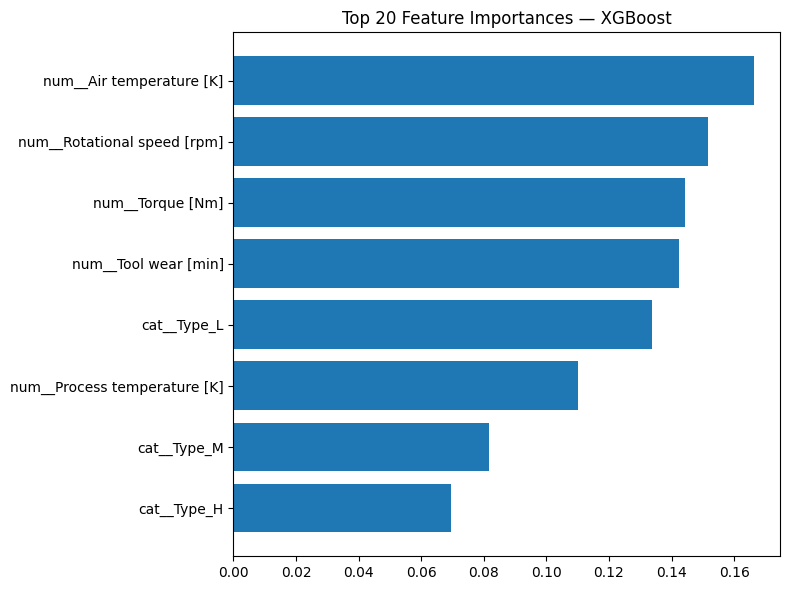

In [34]:
best_row = tuned_table.iloc[0]
best_name = best_row["Model"]
best_pipe = best_pipes_tuned[best_name]
print("BEST MODEL:", best_name)

prep = best_pipe.named_steps["prep"]
model = best_pipe.named_steps["model"]

try:
    fn = prep.get_feature_names_out()
except Exception:
    Xt_tmp = prep.transform(X_train)
    nfeat = Xt_tmp.shape[1]
    fn = np.array([f"f{i}" for i in range(nfeat)])

if hasattr(model, "feature_importances_"):
    imp = model.feature_importances_
    imp_df = pd.DataFrame({"feature": fn, "importance": imp}).sort_values("importance", ascending=False)
    display(imp_df.head(20))

    top = imp_df.head(20).iloc[::-1]
    plt.figure(figsize=(8, 6))
    plt.barh(top["feature"], top["importance"])
    plt.title(f"Top 20 Feature Importances — {best_name}")
    plt.tight_layout()
    plt.show()
else:
    print("No feature_importances_ for this model.")

,feature,mean_abs_shap_overall
3,num__Torque Nm,1.128834
4,num__Tool wear min,1.082699
2,num__Rotational speed rpm,0.676078
0,num__Air temperature K,0.652902
1,num__Process temperature K,0.394306
6,cat__Type_L,0.096208
7,cat__Type_M,0.027128
5,cat__Type_H,0.026340


,feature,mean_abs_shap_Heat Dissipation Failure
0,num__Air temperature K,2.641236
2,num__Rotational speed rpm,2.348563
1,num__Process temperature K,1.229054
4,num__Tool wear min,0.130365
3,num__Torque Nm,0.091881
6,cat__Type_L,0.013545
5,cat__Type_H,0.004768
7,cat__Type_M,0.003168


,feature,mean_abs_shap_No Failure
4,num__Tool wear min,0.480213
3,num__Torque Nm,0.455234
2,num__Rotational speed rpm,0.392045
0,num__Air temperature K,0.382421
1,num__Process temperature K,0.163796
5,cat__Type_H,0.023353
6,cat__Type_L,0.012329
7,cat__Type_M,0.007297


,feature,mean_abs_shap_Overstrain Failure
4,num__Tool wear min,2.331234
3,num__Torque Nm,1.862165
6,cat__Type_L,0.450667
0,num__Air temperature K,0.192888
1,num__Process temperature K,0.122184
2,num__Rotational speed rpm,0.105885
7,cat__Type_M,0.002718
5,cat__Type_H,0.000726


,feature,mean_abs_shap_Power Failure
3,num__Torque Nm,3.287874
2,num__Rotational speed rpm,0.480954
0,num__Air temperature K,0.193088
4,num__Tool wear min,0.171592
1,num__Process temperature K,0.105449
7,cat__Type_M,0.062612
6,cat__Type_L,0.019898
5,cat__Type_H,0.000000


,feature,mean_abs_shap_Random Failures
3,num__Torque Nm,0.617471
1,num__Process temperature K,0.510062
4,num__Tool wear min,0.466192
2,num__Rotational speed rpm,0.408708
0,num__Air temperature K,0.370674
5,cat__Type_H,0.122972
7,cat__Type_M,0.083059
6,cat__Type_L,0.067049


,feature,mean_abs_shap_Tool Wear Failure
4,num__Tool wear min,2.916602
3,num__Torque Nm,0.458378
2,num__Rotational speed rpm,0.320317
1,num__Process temperature K,0.235291
0,num__Air temperature K,0.137104
6,cat__Type_L,0.013761
5,cat__Type_H,0.006223
7,cat__Type_M,0.003911


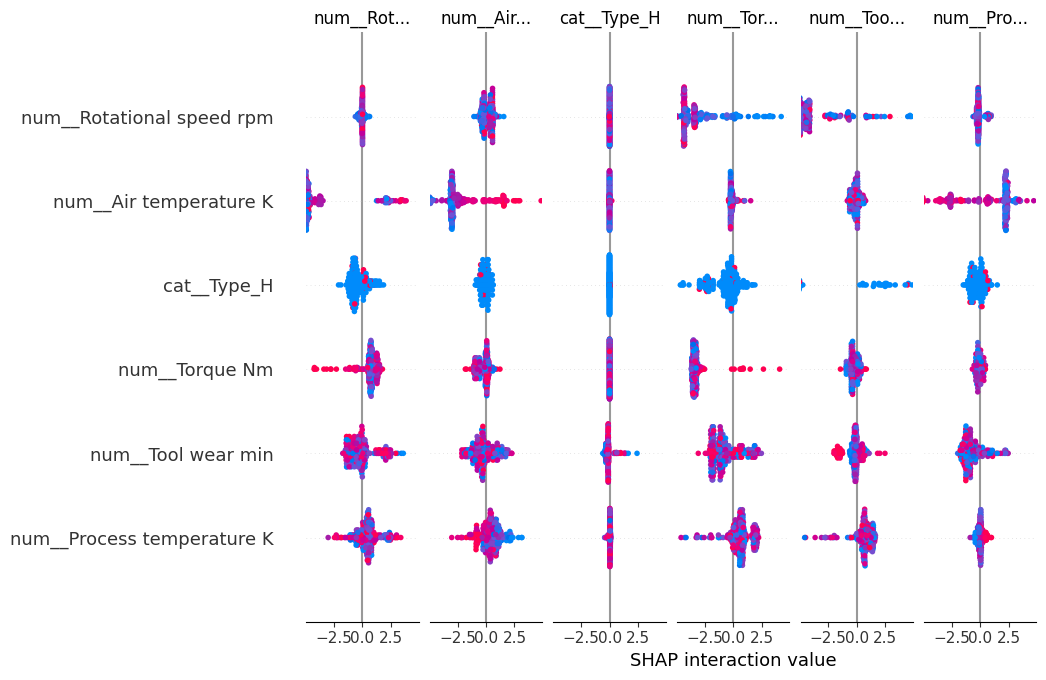

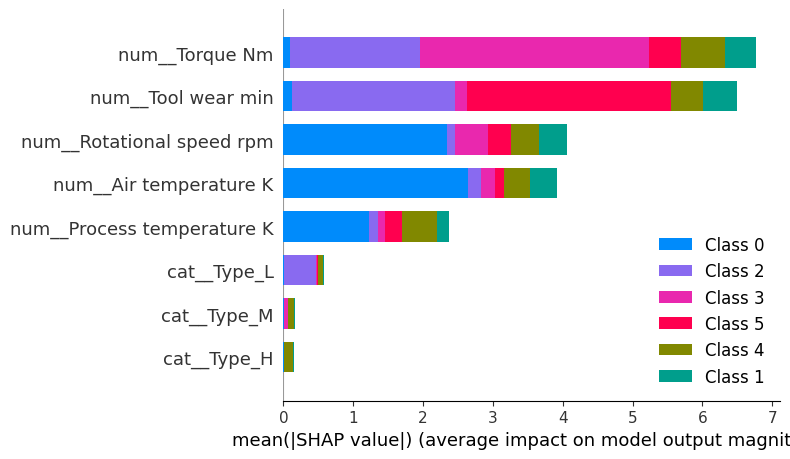

In [35]:
BG_N = min(300, len(X_train))
TEST_N = min(300, len(X_test))

X_te = X_test.sample(TEST_N, random_state=42)

prep = best_pipe.named_steps["prep"]
model = best_pipe.named_steps["model"]

X_te_t = prep.transform(X_te)
if hasattr(X_te_t, "toarray"):
    X_te_t = X_te_t.toarray()

try:
    feat_names = prep.get_feature_names_out()
except Exception:
    feat_names = np.array([f"f{i}" for i in range(X_te_t.shape[1])])

# Sanitize feature names to remove problematic characters for XGBoost
feat_names = [f.replace('[', '').replace(']', '').replace('<', '_') for f in feat_names]

X_te_df = pd.DataFrame(X_te_t, columns=feat_names)

explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_te_df)

if isinstance(shap_vals, list):
    shap_arr = np.stack(shap_vals, axis=2)
else:
    shap_arr = shap_vals
    if shap_arr.ndim == 2:
        shap_arr = shap_arr[:, :, None]

class_names = list(le.classes_)

mean_abs_overall = np.mean(np.abs(shap_arr), axis=(0, 2))
overall_imp = pd.DataFrame({"feature": feat_names, "mean_abs_shap_overall": mean_abs_overall}).sort_values("mean_abs_shap_overall", ascending=False)
display(overall_imp.head(15))

per_class_tables = {}
for c, cname in enumerate(class_names):
    mean_abs_c = np.mean(np.abs(shap_arr[:, :, c]), axis=0)
    t = pd.DataFrame({"feature": feat_names, f"mean_abs_shap_{cname}": mean_abs_c}).sort_values(by=f"mean_abs_shap_{cname}", ascending=False)
    per_class_tables[cname] = t
    display(t.head(10))

shap.summary_plot(shap_vals, X_te_df, show=True)
shap.summary_plot(shap_vals, X_te_df, plot_type="bar", show=True)

In [36]:
# =========================
# Cell 29 (safe save cell)
# =========================

import pandas as pd
import joblib

# Safety: define lists if they don't exist
if "rows_baseline" not in globals():
    rows_baseline = []
if "rows_tuned" not in globals():
    rows_tuned = []

# Build tables if missing
if "baseline_table" not in globals():
    baseline_table = pd.DataFrame(rows_baseline)
    if not baseline_table.empty and "Test_F1(weighted)" in baseline_table.columns:
        baseline_table = baseline_table.sort_values(by="Test_F1(weighted)", ascending=False)

if "tuned_table" not in globals():
    tuned_table = pd.DataFrame(rows_tuned)
    if not tuned_table.empty and "Test_F1(weighted)" in tuned_table.columns:
        tuned_table = tuned_table.sort_values(by="Test_F1(weighted)", ascending=False)

# Build comparison if possible
if "comparison" not in globals():
    parts = []
    if not baseline_table.empty:
        keep_b = [c for c in ["Model","Group","Version","Test_F1(weighted)","Test_F1(macro)","Test_Accuracy"] if c in baseline_table.columns]
        parts.append(baseline_table[keep_b])
    if not tuned_table.empty:
        keep_t = [c for c in ["Model","Group","Version","Test_F1(weighted)","Test_F1(macro)","Test_Accuracy","BestCV_F1_weighted","BestParams"] if c in tuned_table.columns]
        parts.append(tuned_table[keep_t])

    comparison = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    if not comparison.empty and all(c in comparison.columns for c in ["Group","Model","Version"]):
        comparison = comparison.sort_values(by=["Group","Model","Version"])

# Save CSVs (even if empty, it will still create files)
baseline_table.to_csv("baseline_results.csv", index=False)
tuned_table.to_csv("tuned_results_randomized.csv", index=False)
comparison.to_csv("baseline_vs_tuned_randomized.csv", index=False)

# Save model artifacts only if they exist
if "best_pipe" in globals():
    joblib.dump(best_pipe, "best_model_with_tuning.joblib")
    print("Saved: best_model_with_tuning.joblib")
else:
    print("Skipped saving model: 'best_pipe' not found (run tuning + best-model selection cell).")

if "le" in globals():
    joblib.dump(le, "label_encoder.joblib")
    print("Saved: label_encoder.joblib")
else:
    print("Skipped saving encoder: 'le' not found (run target encoding cell).")

# Save SHAP tables only if they exist
if "overall_imp" in globals():
    overall_imp.head(30).to_csv("shap_overall_top30.csv", index=False)
    print("Saved: shap_overall_top30.csv")

if "per_class_tables" in globals():
    for cname, t in per_class_tables.items():
        t.head(30).to_csv(f"shap_{cname}_top30.csv", index=False)
    print("Saved: shap_<class>_top30.csv")

print("Saved: baseline_results.csv, tuned_results_randomized.csv, baseline_vs_tuned_randomized.csv")

Saved: best_model_with_tuning.joblib
Saved: label_encoder.joblib
Saved: shap_overall_top30.csv
Saved: shap_<class>_top30.csv
Saved: baseline_results.csv, tuned_results_randomized.csv, baseline_vs_tuned_randomized.csv


In [37]:
import pandas as pd

print("baseline_table rows:", 0 if "baseline_table" not in globals() else len(baseline_table))
print("tuned_table rows:", 0 if "tuned_table" not in globals() else len(tuned_table))

# show top results if exist
if "baseline_table" in globals() and len(baseline_table) > 0:
    display(baseline_table.head())

if "tuned_table" in globals() and len(tuned_table) > 0:
    display(tuned_table.head())

baseline_table rows: 6
tuned_table rows: 6


,Model,Group,Version,CV_acc,CV_prec_w,CV_rec_w,CV_f1_w,CV_f1_m,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
4,LightGBM,Ensemble,Baseline,0.987684,0.982276,0.987684,0.984490,0.561752,0.989523,0.983837,0.989523,0.986376,0.580147
3,XGBoost,Ensemble,Baseline,0.985981,0.980732,0.985981,0.982696,0.527624,0.985856,0.983106,0.985856,0.984340,0.604586
5,CatBoost,Ensemble,Baseline,0.985063,0.977887,0.985063,0.980984,0.485286,0.987428,0.981543,0.987428,0.984244,0.596763
2,KNN,Non-Ensemble,Baseline,0.976808,0.966457,0.976808,0.968734,0.323905,0.974856,0.962108,0.974856,0.965631,0.297867
1,SVM_RBF,Non-Ensemble,Baseline,0.850099,0.975393,0.850099,0.902615,0.413742,0.827135,0.975490,0.827135,0.889265,0.431384


,Model,Group,Version,BestCV_F1_weighted,BestParams,Test_Accuracy,Test_Precision(weighted),Test_Recall(weighted),Test_F1(weighted),Test_F1(macro)
3,XGBoost,Ensemble,Tuned(Random),0.982976,{'model__colsample_bytree': 0.9726206851751188...,0.988999,0.985068,0.988999,0.986707,0.633058
4,LightGBM,Ensemble,Tuned(Random),0.982938,"{'model__colsample_bytree': 0.89444298503239, ...",0.986904,0.981527,0.986904,0.983823,0.587109
5,CatBoost,Ensemble,Tuned(Random),0.980256,"{'model__depth': 4, 'model__iterations': 366, ...",0.986904,0.981051,0.986904,0.983699,0.593132
2,KNN,Non-Ensemble,Tuned(Random),0.966936,"{'model__n_neighbors': 5, 'model__p': 2, 'mode...",0.974856,0.962108,0.974856,0.965631,0.297867
1,SVM_RBF,Non-Ensemble,Tuned(Random),0.922784,"{'model__C': 72.86653737491046, 'model__gamma'...",0.843897,0.979271,0.843897,0.902142,0.498771


In [38]:
import os
for f in ["best_model_with_tuning.joblib", "label_encoder.joblib"]:
    print(f, "->", os.path.exists(f))

best_model_with_tuning.joblib -> True
label_encoder.joblib -> True


In [39]:
import numpy as np
import pandas as pd

# Use all data (train+test) for clustering since it's unsupervised
X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_all = np.concatenate([y_train, y_test], axis=0)

X_all_t = preprocess.fit_transform(X_all)   # fit on all for clustering
if hasattr(X_all_t, "toarray"):
    X_all_t = X_all_t.toarray()

print("Unsupervised matrix shape:", X_all_t.shape)

Unsupervised matrix shape: (9541, 8)


In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_list = list(range(2, 11))   # 2..10
sil_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_all_t)
    sil = silhouette_score(X_all_t, labels)
    sil_scores.append(sil)
    print(f"k={k}  silhouette={sil:.4f}")

best_k = k_list[int(np.argmax(sil_scores))]
print("Best k (silhouette):", best_k)

k=2  silhouette=0.2221
k=3  silhouette=0.2199
k=4  silhouette=0.1921
k=5  silhouette=0.1925
k=6  silhouette=0.1869
k=7  silhouette=0.1798
k=8  silhouette=0.1809
k=9  silhouette=0.1781
k=10  silhouette=0.1744
Best k (silhouette): 2


In [41]:
km_final = KMeans(n_clusters=best_k, n_init=20, random_state=42)
cluster_labels = km_final.fit_predict(X_all_t)

# Cluster sizes
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Cluster counts:\n", cluster_counts)

# Cluster vs Failure Type (real labels) cross-tab
y_names = le.inverse_transform(y_all.astype(int))
ct = pd.crosstab(pd.Series(cluster_labels, name="Cluster"),
                 pd.Series(y_names, name="Failure Type"),
                 normalize="index") * 100

display(ct.round(2))

Cluster counts:
 0    4765
1    4776
Name: count, dtype: int64


Failure Type,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure
Cluster,,,,,,
0,2.31,95.87,0.73,0.31,0.25,0.52
1,0.02,98.35,0.86,0.31,0.13,0.34


In [42]:
import joblib

ct.round(2).to_csv("kmeans_cluster_vs_failuretype_percent.csv")
joblib.dump(km_final, "kmeans_model.joblib")

print("Saved:")
print("- kmeans_cluster_vs_failuretype_percent.csv")
print("- kmeans_model.joblib")

Saved:
- kmeans_cluster_vs_failuretype_percent.csv
- kmeans_model.joblib
